In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder
from mixed_naive_bayes import MixedNB

In [2]:
names = [
    'age',
    'class_of_worker',
    'industry_code',
    'occupation_code',
   # 'adjusted_gross_income',
    'education',
    'wage_per_hour',
    'enrolled_in_edu_inst_last_wk',
    'marital_status',
    'major_industry_code',
    'major_occupation_code',
    'race',
    'hispanic_Origin',
    'sex',
    'member_of_a_labor_union',
    'reason_for_unemployment',
    'full_or_part_time_employment_stat',
    'capital_gains',
    'capital_losses',
    'divdends_from_stocks',
    #'federal_income_tax_liability',
    'tax_filer_status',
    'region_of_previous_residence',
    'state_of_previous_residence',
    'detailed_household_and_family_stat',
    'detailed_household_summary_in_household',
    'instance_weight',
    'migration_code-change_in_msa',
    'migration_code-change_in_reg',
    'migration_code-move_within_reg',
    'live_in_this_house_1_year_ago',
    'migration_prev_res_in_sunbelt',
    'num_persons_worked_for_employer',
    'family_members_under_18',
    #'total_person_earnings',
    'country_of_birth_father',
    'country_of_birth_mother',
    'country_of_birth_self',
    'citizenship',
    #'total person income',
    'own_business_or_self_employed',
    #'taxable_income_amount',
    "fill_inc_questionnaire_for_veteran's_admin",
    'veterans_benefits',
    'weeks_worked_in_year',
    'year',
    'label'
]
# Since our data has continous and categorical variables
# so we don't assume all data follow gaussian distribution or bernoulli distribution. 
# previously cleanning by gabe

train_MT = pd.read_csv("census-income.data", names=names, header=None, na_values=' ?')
test_MT = pd.read_csv("census-income.test", names=names, header=None, na_values=' ?')
train_MT = train_MT.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
test_MT = test_MT.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
train_MT =train_MT.replace(['Not in universe','?','Not in universe or children','Do not know',
                    'Not in universe under 1 year old','NA'],np.nan)
test_MT=test_MT.replace(['Not in universe','?','Not in universe or children','Do not know',
                    'Not in universe under 1 year old','NA'],np.nan)
train_MT['label'] = train_MT['label'].map({'- 50000.': 0, '50000+.': 1})
test_MT['label'] = test_MT['label'].map({'- 50000.': 0, '50000+.': 1})
train_MT.drop(['instance_weight'], axis=1, inplace=True)
test_MT.drop(['instance_weight'], axis=1, inplace=True)

# since the categorical data be label-encoded accordingly, we need a new cleansed data without dummy variable
# by reading name file, we can find all nominal value excluding instance weight
categorical_features = [1,2,3,4,6,7,8,9,10,11,12,13,14,15,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,39]
le = LabelEncoder()
for i in categorical_features:
    train_MT.iloc[:,i] = le.fit_transform(train_MT.iloc[:,i])
    test_MT.iloc[:,i] = le.fit_transform(test_MT.iloc[:,i])

X_train_MT = train_MT.drop(['label'],axis=1)
X_test_MT = test_MT.drop(['label'],axis=1)
y_train_MT = train_MT['label']
y_test_MT = test_MT['label']

X_train_MT

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,...,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year
0,73,8,0,0,12,0,2,6,23,14,...,4,39,39,39,4,0,2,2,0,1
1,58,5,4,34,16,0,2,0,4,7,...,4,39,39,39,4,0,2,2,52,0
2,18,8,0,0,0,0,1,4,23,14,...,4,40,40,40,0,0,2,2,0,1
3,9,8,0,0,10,0,2,4,23,14,...,0,39,39,39,4,0,2,0,0,0
4,10,8,0,0,10,0,2,4,23,14,...,0,39,39,39,4,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199518,87,8,0,0,5,0,2,2,23,14,...,4,1,39,39,4,0,2,2,0,1
199519,65,4,37,2,1,0,2,2,2,2,...,4,39,39,39,4,0,2,2,52,0
199520,47,8,0,0,16,0,2,2,23,14,...,4,31,31,10,1,0,2,2,52,1
199521,16,8,0,0,0,0,1,4,23,14,...,0,39,39,39,4,0,2,2,0,1


In [3]:
#create three feature selected data
# feature selection w/random forest
rf = RandomForestClassifier(n_estimators=100,
                            max_features='sqrt',
                            oob_score=True,
                            n_jobs=-1,
                            random_state=0,)
rf.fit(X_train_MT, y_train_MT)
# feature importances
importances = pd.Series(rf.feature_importances_, index=X_train_MT.columns)
# depends on the impurity threshold we set
less = importances[importances > 0.01].sort_values(ascending=False)
col_RF = list(less.index)
X_train_MT_RF = X_train_MT[col_RF]
X_test_MT_RF = X_test_MT[col_RF]


# feature selection w/kBest
feature = SelectKBest(score_func=chi2, k=2)
feature.fit(X_train_MT, y_train_MT)
scores = []
for i in range(X_train_MT.shape[1]):
    score = feature.scores_[i]
    scores.append((score, X_train_MT.columns[i]))
    
top20 = sorted(scores, reverse = True)[:20]
important = [feature[1] for feature in top20]
X_train_MT_KB = X_train_MT[important]
X_test_MT_KB = X_test_MT[important]

In [4]:
# feature selection w/lasso
#Then feature selection with lasso regression
lasso = Lasso()
lasso.fit(X_train_MT,y_train_MT)
train_score=lasso.score(X_train_MT,y_train_MT)
test_score=lasso.score(X_test_MT,y_test_MT)
coeff_used = np.sum(lasso.coef_!=0)
print ("training score:", train_score)
print ("test score: ", test_score)
print ("number of features used: ", coeff_used)
print("\n")
lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train_MT,y_train_MT)
train_score001=lasso001.score(X_train_MT,y_train_MT)
test_score001=lasso001.score(X_test_MT,y_test_MT)
coeff_used001 = np.sum(lasso001.coef_!=0)
print ("training score for alpha= 0.01:", train_score001) 
print ("test score for alpha = 0.01: ", test_score001)
print ("number of features used: for alpha = 0.01:", coeff_used001)
print("\n")
lasso005 = Lasso(alpha=0.005, max_iter=10e5)
lasso005.fit(X_train_MT,y_train_MT)
train_score005=lasso005.score(X_train_MT,y_train_MT)
test_score005=lasso005.score(X_test_MT,y_test_MT)
coeff_used005 = np.sum(lasso005.coef_!=0)
print ("training score for alpha= 0.005:", train_score005 )
print ("test score for alpha = 0.005: ", test_score005)
print ("number of features used: for alpha = 0.005:", coeff_used005)
print("\n")
lr = LinearRegression()
lr.fit(X_train_MT,y_train_MT)
lr_train_score=lr.score(X_train_MT,y_train_MT)
lr_test_score=lr.score(X_test_MT,y_test_MT)
print ("LR training score:", lr_train_score )
print ("LR test score: ", lr_test_score)

features = []
for i in range(X_train_MT.shape[1]):
    feature = lasso005.coef_[i]
    features.append((feature, X_train_MT.columns[i]))
    
features_lasso = sorted(features, reverse = True)
lasso_features = [feature for feature in features_lasso if feature[0] != 0]
final_lasso = [feature[1] for feature in lasso_features]
X_train_MT_lasso = X_train_MT[final_lasso]
X_test_MT_lasso = X_test_MT[final_lasso]

training score: 0.12334496018090002
test score:  0.12600392716094067
number of features used:  4


training score for alpha= 0.01: 0.21354198646992717
test score for alpha = 0.01:  0.2162107787479861
number of features used: for alpha = 0.01: 17


training score for alpha= 0.005: 0.22194467679609575
test score for alpha = 0.005:  0.22471918168898886
number of features used: for alpha = 0.005: 19


LR training score: 0.22688158185009522
LR test score:  0.2302514297065138


In [5]:
#important: find categorical variable position for three feature selections
columns = list(X_train_MT.iloc[:,categorical_features].columns)
#get RF categorical variavbles location
position = []
for i in list(X_train_MT_RF.columns):
    position.append(i in columns)
categorical_features_RF = []
for m,n in zip(position, list(X_train_MT_RF.columns)):
    if m:
        categorical_features_RF.append(X_train_MT_RF.columns.get_loc(n))
        
#get KB categorical variavbles location
position = []
for i in list(X_train_MT_KB.columns):
    position.append(i in columns)
categorical_features_KB = []
for m,n in zip(position, list(X_train_MT_KB.columns)):
    if m:
        categorical_features_KB.append(X_train_MT_KB.columns.get_loc(n))

#get lasso categorical variavbles location
position = []
for i in list(X_train_MT_lasso.columns):
    position.append(i in columns)
categorical_features_lasso = []
for m,n in zip(position, list(X_train_MT_lasso.columns)):
    if m:
        categorical_features_lasso.append(X_train_MT_lasso.columns.get_loc(n))

In [6]:
#test MTNB
Mnb = MixedNB(categorical_features)
Mnb.fit(X_train_MT,y_train_MT)

Mnb_1 = MixedNB(categorical_features_RF)
Mnb_1.fit(X_train_MT_RF,y_train_MT)

Mnb_2 = MixedNB(categorical_features_KB)
Mnb_2.fit(X_train_MT_KB,y_train_MT)

Mnb_3 = MixedNB(categorical_features_lasso)
Mnb_3.fit(X_train_MT_lasso,y_train_MT)

[ 9 52 47 17  3  7 24 15  5  9  2  3  6  8  6  6 50 38  8  9  8  9  3  3
  5 43 43 43  5  3  3  3  2]
[47 17 52 24  2 15  9  6  7 38 43  3 43  3  8  8  5]
[52 24 15  9 38  5 17  9  7  2  6  3  8]
[ 2 17 50 52  9 38  5  7 24 47  6  9]


MixedNB(alpha=0.5, var_smoothing=1e-09)

In [9]:
results = pd.DataFrame(data=[["MixedNB", accuracy_score(y_train_MT, Mnb.predict(X_train_MT)) * 100, 
                              accuracy_score(y_test_MT, Mnb.predict(X_test_MT)) * 100,
                              recall_score(y_test_MT, Mnb.predict(X_test_MT)) * 100,
                              precision_score(y_test_MT, Mnb.predict(X_test_MT)) * 100,
                              f1_score(y_test_MT, Mnb.predict(X_test_MT)) * 100],
                             ["MixedNB with RF feaures", accuracy_score(y_train_MT, Mnb_1.predict(X_train_MT_RF)) * 100, 
                              accuracy_score(y_test_MT, Mnb_1.predict(X_test_MT_RF)) * 100,
                              recall_score(y_test_MT, Mnb_1.predict(X_test_MT_RF)) * 100,
                              precision_score(y_test_MT, Mnb_1.predict(X_test_MT_RF)) * 100,
                              f1_score(y_test_MT, Mnb_1.predict(X_test_MT_RF)) * 100], 
                             ["MixedNB with KB featurs", accuracy_score(y_train_MT, Mnb_2.predict(X_train_MT_KB)) * 100, 
                              accuracy_score(y_test_MT, Mnb_2.predict(X_test_MT_KB)) * 100,
                              recall_score(y_test_MT, Mnb_2.predict(X_test_MT_KB)) * 100,
                              precision_score(y_test_MT, Mnb_2.predict(X_test_MT_KB)) * 100,
                              f1_score(y_test_MT, Mnb_2.predict(X_test_MT_KB)) * 100],
                             ["MixedNB with lasso features", accuracy_score(y_train_MT, Mnb_3.predict(X_train_MT_lasso)) * 100, 
                              accuracy_score(y_test_MT, Mnb_3.predict(X_test_MT_lasso)) * 100,
                              recall_score(y_test_MT, Mnb_3.predict(X_test_MT_lasso)) * 100,
                              precision_score(y_test_MT, Mnb_3.predict(X_test_MT_lasso)) * 100,
                              f1_score(y_test_MT, Mnb_3.predict(X_test_MT_lasso)) * 100]],
                       
                       columns=['Model', 'Training Accuracy %', 'Testing Accuracy %','Testing precision %', 'Testing recall %', 'Testing f1_score %'])
results

,Model,Training Accuracy %,Testing Accuracy %,Testing precision %,Testing recall %,Testing f1_score %
0,MixedNB,85.651779,89.819771,67.652764,33.914100,45.179747
1,MixedNB with RF feaures,87.250593,90.873278,62.140317,36.240219,45.780980
2,MixedNB with KB featurs,88.042481,91.348409,50.953767,36.026975,42.209575
3,MixedNB with lasso features,89.774111,91.824542,48.981571,37.733499,42.628025


Text(0.5, 0.98, 'ROC for features selection comparison')

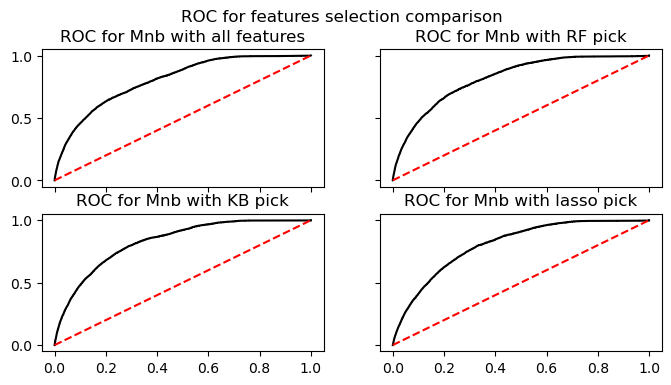

In [10]:
#plot all 
plt.rcParams.update({'figure.figsize':(8,4), 'figure.dpi':100})
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
fpr, tpr, thresholds = roc_curve(y_test_MT, Mnb.predict_proba(X_test_MT)[:,1])
ax[0][0].plot(fpr,tpr,'k')
ax[0][0].plot([0,1],[0,1],'r--')
ax[0][0].set_title('ROC for Mnb with all features')

fpr, tpr, thresholds = roc_curve(y_test_MT, Mnb_1.predict_proba(X_test_MT_RF)[:,1])
ax[0][1].plot(fpr,tpr,'k')
ax[0][1].plot([0,1],[0,1],'r--')
ax[0][1].set_title('ROC for Mnb with RF pick')

fpr, tpr, thresholds = roc_curve(y_test_MT, Mnb_2.predict_proba(X_test_MT_KB)[:,1])
ax[1][0].plot(fpr,tpr,'k')
ax[1][0].plot([0,1],[0,1],'r--')
ax[1][0].set_title('ROC for Mnb with KB pick')

fpr, tpr, thresholds = roc_curve(y_test_MT, Mnb_3.predict_proba(X_test_MT_lasso)[:,1])
ax[1][1].plot(fpr,tpr,'k')
ax[1][1].plot([0,1],[0,1],'r--')
ax[1][1].set_title('ROC for Mnb with lasso pick')


plt.suptitle('ROC for features selection comparison')